In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import gzip
from scipy.io import mmread
import HERGAST
import time
from memory_profiler import memory_usage
import torch

In [2]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/CosMxMouseBrain.h5ad')
adata.var_names_make_unique()
adata.obs['truth']=adata.obs['spatialClusteringAssignments']
adata.obs['truth'] = adata.obs['truth'].astype('category')
adata.raw = adata.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=adata.shape[1])
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 48180 × 950
    obs: 'spatialClusteringAssignments', 'truth'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'RNA_nbclust_clusters_colors', 'spatialClusteringAssignments_colors', 'hvg', 'log1p'
    obsm: 'spatial'

In [3]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [4]:
@measure_resources
def run_pipeline(adata):
    HERGAST.utils.Cal_Spatial_Net(adata,k_cutoff=10)
    HERGAST.utils.Cal_Expression_Net(adata,dim_reduce='HVG',k_cutoff=4)
    train_HERGAST = HERGAST.Train_HERGAST(adata, batch_data=True, num_batch_x_y=(8,8), spatial_net_arg={'verbose':False},exp_net_arg={'verbose':False},dim_reduction='HVG',device_idx=0)
    train_HERGAST.train_HERGAST(n_epochs=200,save_reconstrction=False)
run_pipeline(adata=adata)

------Calculating spatial graph...
Spatial graph contains 481800 edges, 48180 cells.
10.0000 neighbors per cell on average.
------Calculating Expression similarity graph...
Expression graph contains 231598 edges, 48180 cells.
4.8069 neighbors per cell on average.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [07:02<00:00,  2.11s/it]


Function 'run_pipeline' executed in 10.0 minutes and 41.6264 seconds.
Memory usage: 282.61 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 33.75 GB


In [11]:
@measure_resources
def run_leiden(adata):
    sc.pp.neighbors(adata, use_rep='HERGAST')
    sc.tl.leiden(adata, random_state=2024, resolution=0.35,key_added='HERGAST_leiden')
run_leiden(adata=adata)

Function 'run_leiden' executed in 0.0 minutes and 18.8753 seconds.
Memory usage: 3.80 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 33.75 GB


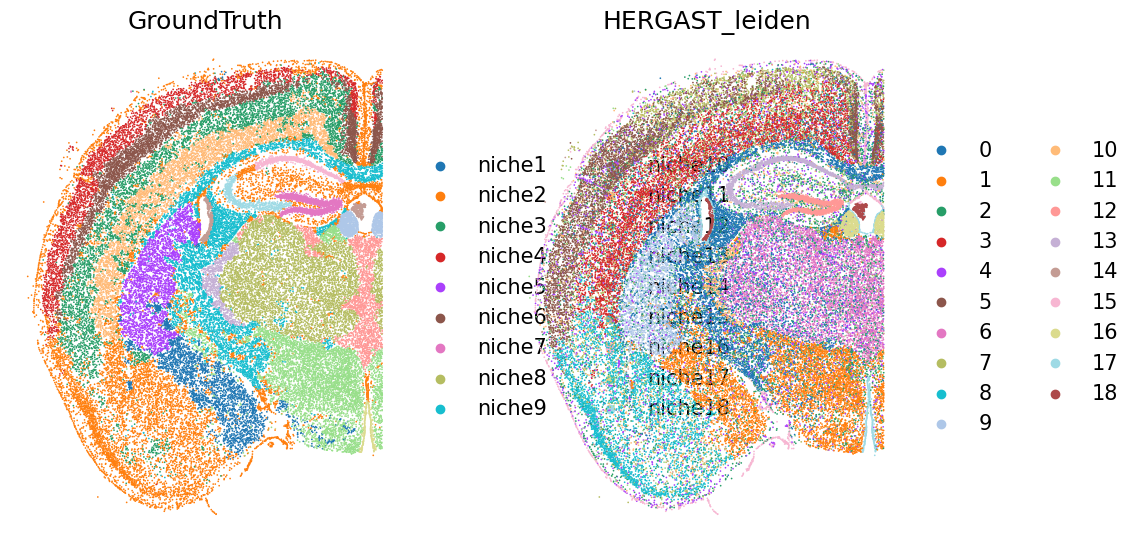

In [12]:
import matplotlib.pyplot as plt
import copy
from scanpy.plotting import palettes
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','HERGAST_leiden'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [13]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['HERGAST_leiden'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.2633402988058339
NMI: 0.4552116933121934
AMI: 0.45454747021557407
FMI: 0.32703335338213185
V-Measure: 0.45521169331219336
Homogeneity: 0.4679341801486397


In [14]:
from sklearn.cluster import KMeans
@measure_resources
def run_kmeans(adata):
    kmeans = KMeans(n_clusters=19, random_state=2024) 
    labels = kmeans.fit_predict(adata.obsm['HERGAST'])
    adata.obs['HERGAST_kmeans']=labels.astype(str)
run_kmeans(adata=adata)

Function 'run_kmeans' executed in 0.0 minutes and 0.8597 seconds.
Memory usage: 3.70 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 33.75 GB


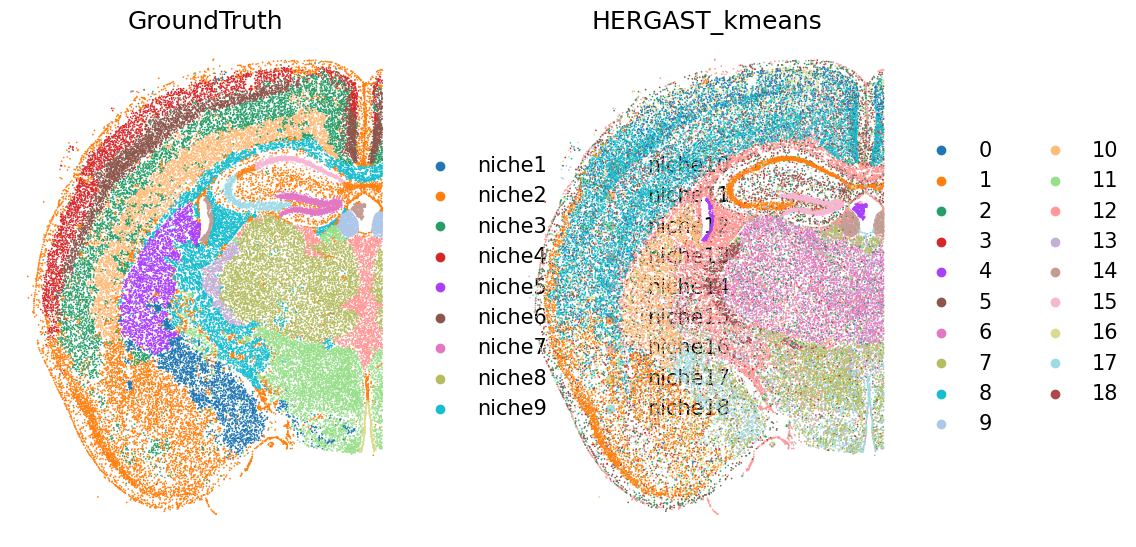

In [15]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,6.5)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata, basis="spatial",s=6, color=['spatialClusteringAssignments','HERGAST_kmeans'],colorbar_loc=None,title='GroundTruth',frameon=False,palette=palettes.default_20)

In [16]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['spatialClusteringAssignments'])
cluster_labels = np.array(adata.obs['HERGAST_kmeans'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.21848408624648274
NMI: 0.3979581144305325
AMI: 0.397226760982498
FMI: 0.2863589514049385
V-Measure: 0.3979581144305325
Homogeneity: 0.41017755158670854


In [17]:
adata.write_h5ad('/home/dbj/STAGATE/HERGAST_CosMx_mousebrain_k_10.h5ad',compression='gzip')